In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io.wavfile import read, write
from scipy import signal
from sklearn.decomposition import NMF
from sklearn.preprocessing import MinMaxScaler
from numpy.linalg import inv
import torch
import torch.optim as optim
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as I
from torch.nn import Sigmoid

from torch import transpose
from sklearn.neural_network import BernoulliRBM
import seaborn as sns
import warnings
warnings.simplefilter('ignore')
import numpy as np
from scipy.signal import butter, lfilter, freqz
import matplotlib.pyplot as plt

In [4]:
from helpers import *
#from nmf_utils import *
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
!ffmpeg -i  "/content/drive/MyDrive/vocal_10.mp3" "vocal.wav"
!ffmpeg -i  "/content/drive/MyDrive/piano_10.mp3" "music.wav"

ffmpeg version 3.4.8-0ubuntu0.2 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7 (Ubuntu 7.5.0-3ubuntu1~18.04)
  configuration: --prefix=/usr --extra-version=0ubuntu0.2 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --enable-gpl --disable-stripping --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librubberband --enable-librsvg --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvorbis --enable-libvpx --enable-libwavpack --enable-libwebp --enable-libx265 --enable-libxml2 --enable-libxvid --enable-lib

In [6]:
def load_data(path_music,path_speech,sec):

  samplerate_m,music = read(path_music)
  music=music[:44100*sec,0]
  length=music.shape[0]/samplerate_m
  print('Shape of the music {}'.format(music.shape[0]))
  print('Length : {:.2f}s'.format(length))
  print('Sample rate : {}'.format(samplerate_m))


  samplerate_s,speech = read(path_speech)
  speech=speech[:44100*sec,0]

  length=speech.shape[0]/samplerate_s
  print('Shape of the speech {}'.format(speech.shape[0]))
  print('Length : {:.2f}s'.format(length))
  print('Sample rate : {}'.format(samplerate_s))

  return music,speech,samplerate_s


In [7]:
path_music  = "music.wav"
path_speech = "vocal.wav"
sec = 1088
music,speech_t,samplerate = load_data(path_music,path_speech,sec)

Shape of the music 47980800
Length : 1088.00s
Sample rate : 44100
Shape of the speech 47980800
Length : 1088.00s
Sample rate : 44100


## Low band Filter

In [8]:
def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y

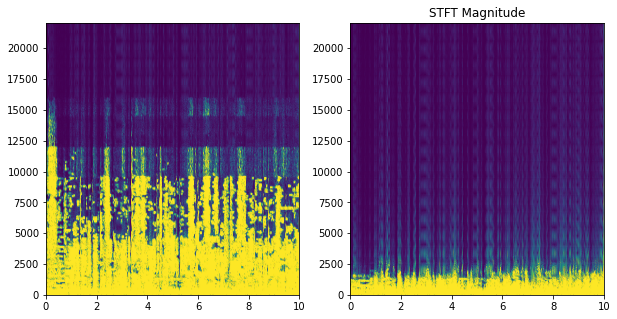

In [9]:
def Viz_Y(t,f,Y,Y_filtered, vmin=0, vmax=20):
    fig,(ax1,ax2) = plt.subplots(1,2,figsize=(10,5))
    ax1.pcolormesh(t, f, Y,vmin=0, vmax=20, shading='gouraud')
    ax2.pcolormesh(t, f, Y_filtered,vmin=0, vmax=20, shading='gouraud')

    plt.title('STFT Magnitude')
    #ax.ylabel('Frequency [Hz]')
    #ax.xlabel('Time [sec]')
    plt.show()

  
speech_filtered = butter_lowpass_filter(speech_t,1000,44100)
WINDOW = 'hamming'
WINDOW_SIZE=480
OVERLAP = 0.6 * WINDOW_SIZE
NFFT=512

f,t,M= signal.stft(speech_t[44100*10:44100*20],44100,window=WINDOW,nperseg=WINDOW_SIZE,noverlap=OVERLAP,nfft=NFFT)    # spectrum  of music signal
f,t,M_1= signal.stft(speech_filtered[44100*10:44100*20],44100,window=WINDOW,nperseg=WINDOW_SIZE,noverlap=OVERLAP,nfft=NFFT)    # spectrum  of music signal

Viz_Y(t,f,np.abs(M),np.abs(M_1), vmin=0, vmax=20)


In [ ]:
f,M_new =  signal.istft(M_1,44100,window=WINDOW,nperseg=WINDOW_SIZE,noverlap=OVERLAP,nfft=NFFT)

In [ ]:
M_new.shape

(441024,)

In [ ]:
write("aa.wav",44100,M_new.astype(np.int16))
 # write("Speech{}.wav".format(iterations), samplerate, speech_estimate.astype(np.int16))


## Resampling

In [10]:
from scipy import signal

In [11]:
rate = 44100/16000
speech_t = signal.resample(speech_t,int(speech_t.shape[0]/rate))
music=signal.resample(music,int(music.shape[0]/rate))
samplerate_m=int(samplerate/rate)
samplerate_s=samplerate_m
samplerate_t=samplerate_m

In [12]:
samplerate_t

16000

# NMF

In [13]:
#from helpers import *

def speech_nmf(Y,n_component,max_iter,a,initt):


  Y[Y==0]=0.0001
  model = NMF(n_components=n_component,
            init=initt,
            alpha=a,
            beta_loss='itakura-saito',
            solver="mu",
            max_iter=max_iter,
            random_state=0)
  B = model.fit_transform(Y)
  G = model.components_
  return B,G, model.reconstruction_err_
def music_nmf(Y,n_component,max_iter,a,initt):


  Y[Y==0]=0.0001
  model = NMF(n_components=n_component,
            init=initt,
            alpha=a,
            beta_loss='itakura-saito',
            solver="mu",
            max_iter=max_iter,
            random_state=0)
  B = model.fit_transform(Y)
  G = model.components_
  return B,G, model.reconstruction_err_




In [14]:
def Reconstruct(B,G,Ns,Nm,Yabs,p):
    
    numerators=[]
    B1=B[:,:Ns]
    B2=B[:,Ns:]
    G1=G[:Ns,:]
    G2=G[Ns:,:]
    
    
    numerators.append(np.power(np.matmul(B1,G1),p))
    numerators.append(np.power(np.matmul(B2,G2),p))

    denominator = np.power(np.matmul(B1,G1),p)+np.power(np.matmul(B2,G2),p)
  
    

    Sources=[]
    Masks=[]
    for i in range(2):

        Sources.append(np.multiply(numerators[i]/denominator,Yabs))
        Masks.append(numerators[i]/denominator)

    #print('Source shape = {}'.format(Sources[0].shape))
    
    return Sources,Masks
def training(music_s,
               speech_s,
                          init,

               s_component = 128,
               m_component = 128,
               iterations = 200,
               s_alpha = 0,
               m_alpha = 0,
               p = 2,
             samplerate=samplerate_t,
                ):
  ###################################   STFT   #######################################
  WINDOW = 'hamming'
  WINDOW_SIZE=480
  OVERLAP = 0.6 * WINDOW_SIZE
  NFFT=512
  #_,speech_s,music_s = get_mixed_signal(spe)

  f,t,M= signal.stft(music_s,samplerate,window=WINDOW,nperseg=WINDOW_SIZE,noverlap=OVERLAP,nfft=NFFT)    # spectrum  of music signal

  f,t,S= signal.stft(speech_s,samplerate,window=WINDOW,nperseg=WINDOW_SIZE,noverlap=OVERLAP,nfft=NFFT)   # spectrum  of speech signal

  #####################################################################################


  ## Magnitude of each spectrum source 

  M_abs=np.abs(M)

  S_abs=np.abs(S)




  ##############################   NMF Training   #####################################
  print("Training Stage ....")
  B_speech,_,error_speech = speech_nmf(S_abs,s_component,iterations,s_alpha,initt=init)
  B_music,_,error_music =   music_nmf(M_abs,m_component,iterations,m_alpha,initt=init)
  print("Training finish ! ....")

  #####################################################################################

  B_mixed = np.concatenate([B_speech,B_music],axis = 1)                                # Concatenation of both  training dictionnaries
  print("SPEECH reconstruction Loss {}".format(error_speech))
  print("MUSIC reconstruction Loss {}".format(error_music))

  return B_mixed

In [15]:

def mixed_nmf(B_mixed,
              Y_test,
              iterations,
              a,
              initt,
              ):
  n_components=B_mixed.shape[1]
  model = NMF(n_components=n_components,
              init=initt,
              alpha=a,
              beta_loss='itakura-saito',
              solver="mu",
              max_iter=iterations,
              random_state=0)
  
  model.fit(np.transpose(Y_test))

  model.components_ = np.transpose(B_mixed)

  G0 = model.transform(np.transpose(Y_test))

  return np.transpose(G0),model.reconstruction_err_,model.components_

In [16]:
def validation(B_mixed,
               speech,
               music,
               s_component,
               m_component,
               alpha,
               init,
               smr,
               iterations,
               samplerate=samplerate_t
               ):

  mixed_signal , speech_signal, music_signal = get_mixed_signal(speech,music,smr)
  #mixed_signal = mixed_signal
  WINDOW = 'hamming'
  WINDOW_SIZE=480
  OVERLAP = 0.6 * WINDOW_SIZE
  NFFT=512

  f,t,mixed_spectrum = signal.stft(mixed_signal,window=WINDOW,nperseg=WINDOW_SIZE,noverlap=OVERLAP,nfft=NFFT) # spectrum  of mixed signal

  mixed_abs = np.abs(mixed_spectrum)
  G_mixed,reconstruction,update_or_not = mixed_nmf(B_mixed,
              mixed_abs,
              iterations,
              alpha,
              init
              )
  #B_mixed,G_mixed,error_speech = speech_nmf(mixed_abs,s_component,iterations,0)
  print("ok")
  sources,masks = Reconstruct(B_mixed,
                              G_mixed,
                              s_component,
                              m_component,
                              mixed_spectrum,
                              2)
  _, speech_estimate =  signal.istft( sources[0],samplerate,window=WINDOW,nperseg=WINDOW_SIZE,noverlap=OVERLAP,nfft=NFFT)
  _, music_estimate =    signal.istft(sources[1],samplerate,window=WINDOW,nperseg=WINDOW_SIZE,noverlap=OVERLAP,nfft=NFFT)
  print("Separation finish ! ....")
  #print(speech_estimate.shape, speech.shape)
  sdr_speech = SDR(speech_estimate[:speech_signal.shape[0]],speech_signal)
  
  sdr_music = SDR(music_estimate[:music_signal.shape[0]],music_signal)
  print("Evaluation .....")
  #print(update_or_not)
  print("SMR ={} N_components ={}: \nSDR Speech = {}\nSDR Music  = {}".format(smr,s_component,sdr_speech,sdr_music))
  print(reconstruction)

  write("Speech{}.wav".format(iterations), samplerate, speech_estimate.astype(np.int16))
  write("Music.wav".format(iterations), samplerate, music_estimate.astype(np.int16))
  return smr,sdr_speech,sdr_music,sources[0],sources[1],mixed_abs

# Train / Validation

In [17]:
speech = butter_lowpass_filter(speech_t,2000,16000)

In [18]:
train_speech   = np.hstack((speech[samplerate_t*60:samplerate_t*440] , speech[samplerate_t*723:samplerate_t*930]))
train_music    = np.hstack((music[samplerate_t*60:samplerate_t*440] ,  music[samplerate_t*723:samplerate_t*930]))

test_speech ,test_music =  speech[samplerate_t*580:samplerate_t*680]  , music[samplerate_t*580:samplerate_t*680]

## Test different configurations 5,8,10,32 components

In [ ]:
B_all_list= []
for c in [5,8,10,32]:
  B_mixed = training(train_music,
               train_speech,
               s_component = c,
               m_component = c,
               iterations = 100,
               s_alpha = 0,
               m_alpha = 0,
               p = 2,
               init="random")
  B_mixed_new = MinMaxScaler().fit_transform(B_mixed)
  B_all_list.append(B_mixed_new)

In [21]:
B_mixed = np.load("b_train.npy")
my_dict_2= {}
info_dict_2 = {} 
for s in [0]:
  smr,sdr_speech,sdr_music,spectrum_s1,spectrum_s2,Y_mag = validation(B_mixed,test_speech, ## n component = 8 +8
                  test_music,
                  smr=s,
                  iterations=100,
                  m_component=8,
                  s_component=8,
                  alpha=0,
                  init="random"
)
  
  my_dict_2["SMR = {}".format(smr)] = info_dict_2 = ["SDR Speech = {:.2f} SDR Music = {:.2f}".format(sdr_speech,sdr_music)]


SMR = 0.00
ok
Separation finish ! ....
Evaluation .....
SMR =0 N_components =8: 
SDR Speech = 2.1522883934757027
SDR Music  = 2.152288393475696
984.6859821420039


Best with : 


fc = 2000


8 components for every sources.

init random.

ALpha = 0

100 iterations for train and test.



In [ ]:
np.save("b_train",B_all_list[1])

In [22]:
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as I
from torch.nn import Sigmoid

In [23]:
from torch.utils.data import Dataset, DataLoader


class AudioDataset(Dataset):
    """Sources dataset."""

    def __init__(self, Y, s1,s2):
        
        self.s1 = torch.tensor(s1)
        self.s2 = torch.tensor(s2)
        self.Y = Y
        
    def __len__(self):
        return self.s1.size()[0]

    def __getitem__(self, idx):
        
        return {'Y':self.Y[idx,:],'s1': self.s1[idx,:], 's2': self.s2[idx,:]}

In [ ]:
spectrum_s1.shape

(257, 5001)

In [24]:
# load training data in batches
from sklearn.preprocessing import MinMaxScaler 

s1_mag = np.abs(spectrum_s1).astype("float32")
s2_mag = np.abs(spectrum_s2).astype("float32")

s1_mag_scaled = MinMaxScaler().fit_transform(s1_mag).reshape(-1,257)
s2_mag_scaled = MinMaxScaler().fit_transform(s2_mag).reshape(-1,257)
Y_mag_scaled = MinMaxScaler().fit_transform(Y_mag).reshape(-1,257)


dataset=AudioDataset(Y_mag_scaled, s1_mag_scaled, s2_mag_scaled)

print('Number of samples in the audio is {}'.format(len(dataset)))

### First dataloader
batch_size = 256
train_loader = DataLoader(dataset, 
                          batch_size=batch_size,
                          shuffle=False, 
                          num_workers=0)

Number of samples in the audio is 8335


In [88]:
class RBM(nn.Module):

    def __init__(self,
                 visible_size,
                 hidden_size):
        super(RBM, self).__init__()
        self.input_layer = visible_size
        self.output_layer = hidden_size
        self.dropout = torch.nn.Dropout(0.005)
        
        self.feed = nn.Linear(visible_size, hidden_size,bias=True)  

    def forward(self, x):
        h = Sigmoid()(self.dropout(self.feed(x)))       # x -> h 

        x_reconstructed = (self.dropout(torch.matmul(h,self.feed.weight)))
        
        h_reconstructed = Sigmoid()(self.dropout(self.feed(x_reconstructed)))# h-> x'



        return h, x_reconstructed,h_reconstructed



def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_uniform(m.weight)
        m.bias.data.fill_(0.01)


In [89]:
def training_rbm(model,               ### Train LOOP OF RBM
                 trainloader,
                 learning_rate = 0.001,
                 n_epochs=200,
                 l2_penalty=0.01):

  
  loss_s1 = []
  loss_s2 = []
  ## weights initialization
  model.apply(init_weights)

  criterion = torch.nn.MSELoss()
  optimizer = torch.optim.SGD(model.parameters(),lr=learning_rate,weight_decay=l2_penalty)
  scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, min_lr = 0.09e-3,
                                                         mode = 'min',
                                                         factor=0.9999,
                                                         verbose=True
                                                         ,patience=11)

  print('Begin Training.....')

  for epoch in range(n_epochs):  # loop over the dataset multiple times

      running_loss = 0.0
      for i,data in enumerate(trainloader):
          a = model.feed.weight.t()  


          model.zero_grad()     

          h1,x_reconstructed_1,h_reconstructed_1 = model(data['s1'])     ##  calcul x_reconstructed
          loss_1 = -torch.sum(a*(torch.matmul(data['s1'].t(),h1) - torch.matmul(x_reconstructed_1.t(),h_reconstructed_1)))/(data['s1'].shape[0]*data['s1'].shape[1])
          #loss_1 = torch.sum(KL_divergence(data['s1'],x_reconstructed_1))
          loss_1.backward()
          optimizer.step()    ## W -= W - lr*dL/dW

          mse_1 = criterion(data['s1'],x_reconstructed_1)
          loss_s1.append(mse_1)
          model.zero_grad()     


          h2,x_reconstructed_2,h_reconstructed_2 = model(data['s2'])     ##  calcul x_reconstructed
          loss_2 = -torch.sum(a*(torch.matmul(data['s2'].t(),h2) - torch.matmul(x_reconstructed_2.t(),h_reconstructed_2)))/(data['s2'].shape[0]*data['s2'].shape[1])
          #loss_2 = torch.sum(KL_divergence(data['s2'],x_reconstructed_2))

          loss_2.backward()
          optimizer.step()
          mse_2 = criterion(data['s2'],x_reconstructed_2)
          loss_s2.append(mse_2)
          #loss = torch.add(loss_1)#,loss_2)
                ## W* (xh_t - x'_t.  h'_t)
              ## (xh_t - x'_t. h'_t)
      scheduler.step(epoch)
      if epoch%10 == 0:
        print("epochs {} MSE Loss {}".format(epoch,torch.mean(criterion(data['s1'],x_reconstructed_1) + criterion(data['s2'],x_reconstructed_2) )))
  print('Finished Training')

  
   
def train_layer( visible_size,hidden_size,      # this function allows us to train every layer separately, considering new dataloader that will feed into the new visible layer
                 s1,s2,
                 learning_rate,
                 epochs=2,

                 batch_size=256
                ):
  
  model = RBM(visible_size, hidden_size)        # Declare the model




  dataset=AudioDataset(Y_mag_scaled, s1, s2)   # Dataloader
  train_loader = DataLoader(dataset, 
                            batch_size=batch_size,
                            shuffle=False, 
                            num_workers=0)
  
  training_rbm(model, train_loader,learning_rate,n_epochs=epochs)      ## Train the layer according to its inputs ( see argument of the function "s1,s2")


  h_1,_,_ = model(torch.from_numpy(s1).float())     ## Inference of spectra magnitude of source 1
  h_2,_,_ = model(torch.from_numpy(s2).float())     ## Inference of spectra magnitude of source 1

  return model,h_1.cpu().detach().numpy(),h_2.cpu().detach().numpy()


In [90]:
n_epochs = 150
bs = 256
lr = 0.001

## Training

In [91]:
model_1, h1_1, h_2_1 = train_layer(257,
                                   100,
                                   s1_mag_scaled,
                                   s2_mag_scaled,
                                   learning_rate = lr,
                                   epochs=n_epochs,
                                   batch_size=bs)

h1,x_reconstructed_1,h_reconstructed_1 = model_1(torch.from_numpy(s1_mag_scaled).float())



Begin Training.....
epochs 0 MSE Loss 0.284812867641449
epochs 10 MSE Loss 0.18445377051830292
Epoch    13: reducing learning rate of group 0 to 9.9990e-04.
epochs 20 MSE Loss 0.12460407614707947
Epoch    25: reducing learning rate of group 0 to 9.9980e-04.
epochs 30 MSE Loss 0.08679372072219849
Epoch    37: reducing learning rate of group 0 to 9.9970e-04.
epochs 40 MSE Loss 0.06176792457699776
Epoch    49: reducing learning rate of group 0 to 9.9960e-04.
epochs 50 MSE Loss 0.044703707098960876
Epoch    61: reducing learning rate of group 0 to 9.9950e-04.
epochs 60 MSE Loss 0.032724905759096146
epochs 70 MSE Loss 0.024221695959568024
Epoch    73: reducing learning rate of group 0 to 9.9940e-04.
epochs 80 MSE Loss 0.018056001514196396
Epoch    85: reducing learning rate of group 0 to 9.9930e-04.
epochs 90 MSE Loss 0.013539147563278675
Epoch    97: reducing learning rate of group 0 to 9.9920e-04.
epochs 100 MSE Loss 0.010238869115710258
Epoch   109: reducing learning rate of group 0 to 9

In [92]:
torch.save(model_1.state_dict(), "w_layer_1")
del model_1

In [95]:
model_2, h1_2,h_2_2 = train_layer(100,
                                  50,
                                  h1_1,
                                  h_2_1,
                                  epochs=n_epochs,
                                  learning_rate = 0.001,
                                  batch_size=bs)
torch.save(model_2.state_dict(), "w_layer_2")

del model_2

Begin Training.....
epochs 0 MSE Loss 0.7368409633636475
epochs 10 MSE Loss 0.5723329782485962
Epoch    13: reducing learning rate of group 0 to 9.9990e-04.
epochs 20 MSE Loss 0.45616990327835083
Epoch    25: reducing learning rate of group 0 to 9.9980e-04.
epochs 30 MSE Loss 0.3685527443885803
Epoch    37: reducing learning rate of group 0 to 9.9970e-04.
epochs 40 MSE Loss 0.3023569881916046
Epoch    49: reducing learning rate of group 0 to 9.9960e-04.
epochs 50 MSE Loss 0.25228631496429443
Epoch    61: reducing learning rate of group 0 to 9.9950e-04.
epochs 60 MSE Loss 0.21470600366592407
epochs 70 MSE Loss 0.18786540627479553
Epoch    73: reducing learning rate of group 0 to 9.9940e-04.
epochs 80 MSE Loss 0.16864395141601562
Epoch    85: reducing learning rate of group 0 to 9.9930e-04.
epochs 90 MSE Loss 0.1547439694404602
Epoch    97: reducing learning rate of group 0 to 9.9920e-04.
epochs 100 MSE Loss 0.145197793841362
Epoch   109: reducing learning rate of group 0 to 9.9910e-04.


In [97]:
model_3, h1_3,h_2_3 = train_layer(50,
                                  10,
                                  h1_2,
                                  h_2_2,
                                  epochs=n_epochs,
                                  learning_rate = 0.005,
                                  batch_size=bs)
torch.save(model_3.state_dict(), "w_layer_3")

del model_3

Begin Training.....
epochs 0 MSE Loss 0.7730900049209595
epochs 10 MSE Loss 0.5209794044494629
Epoch    13: reducing learning rate of group 0 to 4.9995e-03.
epochs 20 MSE Loss 0.3308075964450836
Epoch    25: reducing learning rate of group 0 to 4.9990e-03.
epochs 30 MSE Loss 0.23667936027050018
Epoch    37: reducing learning rate of group 0 to 4.9985e-03.
epochs 40 MSE Loss 0.199667289853096
Epoch    49: reducing learning rate of group 0 to 4.9980e-03.
epochs 50 MSE Loss 0.18297691643238068
Epoch    61: reducing learning rate of group 0 to 4.9975e-03.
epochs 60 MSE Loss 0.17922544479370117
epochs 70 MSE Loss 0.17542517185211182
Epoch    73: reducing learning rate of group 0 to 4.9970e-03.
epochs 80 MSE Loss 0.17386844754219055
Epoch    85: reducing learning rate of group 0 to 4.9965e-03.
epochs 90 MSE Loss 0.17325595021247864
Epoch    97: reducing learning rate of group 0 to 4.9960e-03.
epochs 100 MSE Loss 0.17336374521255493
Epoch   109: reducing learning rate of group 0 to 4.9955e-03

# DNN

In [102]:
class DNN(nn.Module):

    def __init__(self,d):
        super(DNN, self).__init__()
        self.relu = torch.nn.ReLU()
        self.sigmoid = torch.nn.Sigmoid()
        self.fc1 = nn.Linear(d, 100)  # d is dimension of the input.
        self.fc2 = nn.Linear(100, 50)
        self.fc3 = nn.Linear(50, 10)
        self.fc4 = nn.Linear(10,2)
        

    def forward(self, x):
        x = self.sigmoid(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.sigmoid(self.fc4(x))


        return x

In [103]:
dnn_model = DNN(d=257)
model_1 = RBM(257,100)
model_1.load_state_dict(torch.load("w_layer_1"))
model_2 = RBM(100,50)
model_2.load_state_dict(torch.load("w_layer_2"))
model_3 = RBM(50,10)
model_3.load_state_dict(torch.load("w_layer_3"))

<All keys matched successfully>

In [104]:
with torch.no_grad():
    dnn_model.fc1.weight = model_1.feed.weight
    dnn_model.fc2.weight = model_2.feed.weight
    dnn_model.fc3.weight = model_3.feed.weight

In [105]:
def gain_params(s1,s2,y):

        l2_s1 = torch.norm(s1.float(),2, None)
                 
        l2_s2 = torch.norm(s2.float(),2, None)
               
        l2_Y = torch.norm(y.float(),2, None)
              
        # u is initialized by the l2-norm of the initial NMF source estimate sˆ1 
        # divided by the l2-norm of the mixed signal y
        u = torch.div(l2_s1, l2_Y) 

        # v is initialized by the same manner
        v = torch.div(l2_s2, l2_Y)

        return u,v
    
def gain_params_vec(s1,s2,y):

        l2_s1 = torch.norm(s1.float().t(),2, True)
                 
        l2_s2 = torch.norm(s2.float().t(),2, True)
               
        l2_Y = torch.norm(y.float().t(),2, True)
              
        # u is initialized by the l2-norm of the initial NMF source estimate sˆ1 
        # divided by the l2-norm of the mixed signal y
        u = torch.div(l2_s1, l2_Y) 

        # v is initialized by the same manner
        v = torch.div(l2_s2, l2_Y)

        return u,v
    
    
def feed_(x):
    
    f = model(x)
    f1 = f[0] 
    f2 = f[1]
    return f1,f2

def energy_1(x_source1):
    
    f1,f2 = feed_(x_source1)
    e1 = (1 - f1 ).pow(2) + f2.pow(2)
    return e1 

def energy_2(x_source2):

    f1,f2 = feed_(x_source2)
    e2 = f1.pow(2) + (1 - f2 ).pow(2) 
    return e2

def E_err(s1,s2,y):
  
    u,v = gain_params_vec(s1,s2,y) 
    return torch.norm(torch.mul(u,s1) + torch.mul(v,s2) - y,'fro',None)

def E_err_vec(s1,s2,y,u,v):
  
    return torch.norm(u*s1 + v*s2 - y,'fro',None)


def relu(x):
    return torch.nn.ReLU()(x)

def nonnegative_constraint(s1,s2,y,u,v):  
    
    u_sum  = torch.sum(relu(u))
    v_sum  = torch.sum(relu(v))
    x1_sum = torch.sum(relu(s1))
    x2_sum = torch.sum(relu(s2))
    total_sum = 1 / (u_sum + v_sum + x1_sum + x2_sum)    #vector containing all the unknowns which must all be nonnegative

    return total_sum 


def nonneg_constraint(s1,s2,u,v):
    
    R=min([s1.min().item(),s2.min().item(),u,v,0])
    
    return R**2

In [106]:
spectrum_s1_ = MinMaxScaler().fit_transform(np.abs(spectrum_s1))
spectrum_s2_ = MinMaxScaler().fit_transform(np.abs(spectrum_s2))
Y_mag_ = MinMaxScaler().fit_transform(Y_mag)

In [107]:
def Criteria(s1,s2,Yabs,u,v,i) :
    
    # Feed forward and get energy 1 and 2
    e1 = energy_1(s1[:,i].float())
    e2 = energy_2(s2[:,i].float())
    
    # Get least square error :
    e_rr=E_err_vec(s1[:,i], s2[:,i], Yabs[:,i],u[i],v[i])
    
    # Non negative constraint
    R = nonneg_constraint(s1[:,i], s2[:,i], u[i], v[i])
    


   
    return e1 + e2 + e_rr 
    

In [108]:
print(torch.cuda.is_available())

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

True
cuda:0


In [109]:
def validation_dnn(s1,s2,u,v):
 # s1_ = scaler_1.inverse_transform(s1.cpu().detach().numpy())
  #s2_ = scaler_2.inverse_transform(s2.cpu().detach().numpy())
  #Y_ = scaler_3.inverse_transform(Yabs.cpu().detach().numpy())
  mixed_signal , speech_signal, music_signal = get_mixed_signal(test_speech,test_music,0)
  f,t,mixed_spectrum = signal.stft(mixed_signal,window=WINDOW,nperseg=WINDOW_SIZE,noverlap=OVERLAP,nfft=NFFT) # spectrum  of mixed signal

  new_s1 = (u*s1).cpu().detach().numpy()
  new_s2 = (v*s2).cpu().detach().numpy()

 # s1_new = (mixed_spectrum*(new_s1)**2) /((new_s1)**2 + (new_s2)**2 )
  #s2_new = (mixed_spectrum*(new_s2)**2) /((new_s1)**2 + (new_s2)**2 )
  s1_new = (mixed_spectrum*new_s1) /(new_s1 + new_s2 + 0.0001 )
  s2_new = (mixed_spectrum*new_s2) /(new_s1 + new_s2 + 0.0001 )


  _, speech_estimate =  signal.istft( s1_new,samplerate,window=WINDOW,nperseg=WINDOW_SIZE,noverlap=OVERLAP,nfft=NFFT)
  _, music_estimate =  signal.istft( s2_new,samplerate,window=WINDOW,nperseg=WINDOW_SIZE,noverlap=OVERLAP,nfft=NFFT)

  print("Separation finish ! ....")
  #print(speech_estimate.shape, speech.shape)
  sdr_speech = SDR(speech_estimate[:speech_signal.shape[0]],speech_signal)
  sdr_music = SDR(music_estimate[:music_signal.shape[0]],music_signal)

  print("SDR Speech = {}\n SDR Music = {}".format(sdr_speech,sdr_music))

In [113]:
s1 = torch.tensor(spectrum_s1_, dtype = torch.float32)
s2 = torch.tensor(spectrum_s2_,dtype=torch.float32)
Yabs = torch.tensor(Y_mag_,dtype=torch.float32)
u,v = gain_params_vec(s1, s2, Yabs)
model = DNN(257)

from torch.optim import LBFGS, Adam,SGD
s1 = s1.to(device)
s2 = s2.to(device)
u = u.to(device)
v = v.to(device)
Yabs = Yabs.to(device)

s1.requires_grad = False
s2.requires_grad = False
u.requires_grad = True
v.requires_grad = True
Yabs.requires_grad = False
params = list(model.parameters()) + [u] + [v] 
optimizer= SGD(params, lr=0.01)

In [114]:
L2_LOSS=torch.norm(u*s1 + v*s2 - Yabs,'fro',None)
print('Initial Loss = {}'.format(L2_LOSS))

Initial Loss = 175.3367462158203


In [ ]:

N_epochs = 100

model = model.to(device)
model.train()

Yabs = Yabs.to(device)
for e in range(N_epochs):
    
    loss_e=0.0
    for i in range(s1.shape[1]):

            optimizer.zero_grad()

            loss = Criteria(s1,s2,Yabs,u,v,i).to(device)
            loss.backward()
            # fill zeros into the first row of grad
            u.grad.data[:i].fill_(0)
            u.grad.data[i+1:].fill_(0)
            
            v.grad.data[:i].fill_(0)
            v.grad.data[i+1:].fill_(0)
           # s1.grad.data[:,:i].fill_(0)
           # s1.grad.data[:,i+1:].fill_(0)
           # s2.grad.data[:,:i].fill_(0)
           # s2.grad.data[:,i+1:].fill_(0)



            optimizer.step()
            loss_e+=loss
   
    validation_dnn(s1,s2,u,v)
    #print(model.fc1.weight[0])        
    print('Epoch {} , Loss = {:.2f}'.format(e,loss_e/s1.shape[1]))

SMR = 0.00
Separation finish ! ....
SDR Speech = 2.1891386549027687
 SDR Music = 2.1891706641666437
Epoch 0 , Loss = 2.12
SMR = 0.00
Separation finish ! ....
SDR Speech = 2.190892491480051
 SDR Music = 2.190922545388623
Epoch 1 , Loss = 1.56
SMR = 0.00
Separation finish ! ....
SDR Speech = 2.192654544245532
 SDR Music = 2.1926825173925826
Epoch 2 , Loss = 1.51
SMR = 0.00
Separation finish ! ....
SDR Speech = 2.194421901439754
 SDR Music = 2.1944476156272206
Epoch 3 , Loss = 1.46
SMR = 0.00
Separation finish ! ....
SDR Speech = 2.1962054467089045
 SDR Music = 2.1962287816834576
Epoch 4 , Loss = 1.41
SMR = 0.00
Separation finish ! ....
SDR Speech = 2.197972697878723
 SDR Music = 2.1979934211901746
Epoch 5 , Loss = 1.37
SMR = 0.00
Separation finish ! ....
SDR Speech = 2.199772384819608
 SDR Music = 2.1997904018485883
Epoch 6 , Loss = 1.32
SMR = 0.00
Separation finish ! ....
SDR Speech = 2.2016319420568786
 SDR Music = 2.201647001146724
Epoch 7 , Loss = 1.27
